In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
import pandas as pd

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
img_list =os.listdir('/content/drive/MyDrive/ET610-ENDSEM-Q1/Data') # Making a list of all image names in the folder

In [ ]:
img_list[5]

'61_3.jpg'

(480, 640, 3)


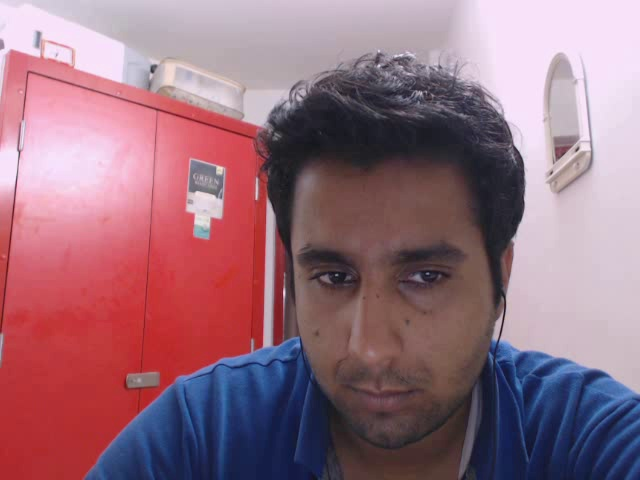

In [ ]:
img=cv2.imread('/content/drive/MyDrive/ET610-ENDSEM-Q1/Data/'+str(img_list[5]), cv2.IMREAD_COLOR)  #printing a random Image
print(img.shape)
cv2_imshow(img)    

Creating a the "labels" array from CSV file in which annotation are done.

In [ ]:
labels_file=pd.DataFrame(pd.read_csv('/content/drive/MyDrive/ET610-ENDSEM-Q1/labels.csv'))
labels=np.array(labels_file["Naveen"])

In [ ]:
labels

array([0, 0, 0, ..., 0, 0, 0])

Checking the shape of an image from the dataset.

---



In [ ]:
from PIL import Image
img= Image.open('/content/drive/MyDrive/ET610-ENDSEM-Q1/Data/1_2.jpg')
np_img = np.array(img)

In [ ]:
print("Shape of a random Image:",np.shape(np_img))

Shape of a random Image: (480, 640, 3)


Creating a dataset of all images from the folder.

In [ ]:
x1=[]
for i in range(164):
    for j in range(1,11):
        img= Image.open("/content/drive/MyDrive/ET610-ENDSEM-Q1/Data/" + str(i)+"_"+str(j)+".jpg").convert('LA')  #converting image to greyscale for easy training purposes
        i1= img.resize((28, 28))
        np_img = np.array(i1)
        x1.append(np_img)
      

In [ ]:
x=np.array(x1,dtype='uint8')

Shape of the Complete dataset

In [ ]:
np.shape(x)

(1640, 28, 28, 2)

Splitting the dataset into Test and Train.

In [ ]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x,labels, test_size = 0.3, random_state = 123)

Scaling the dataset.

In [ ]:
xTrain=xTrain/255
XTest=xTest/255

Building the "CNN Model" from scratch.

In [ ]:
# input shape
INPUT_SHAPE = (28,28,2)

# sequential model
model = tf.keras.models.Sequential()
# conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# output layer with 5 labels
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# compiling the model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# viewing model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

Defning the hyperparameters of the model.

Training the model with " EarlyStopping callback "

In [ ]:
EPOCHS = 20
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(xTrain,yTrain,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/20
33/33 [==============================] - 1s 26ms/step - loss: 0.3957 - accuracy: 0.8974 - val_loss: 0.4441 - val_accuracy: 0.8870
Epoch 2/20
33/33 [==============================] - 1s 25ms/step - loss: 0.3910 - accuracy: 0.9003 - val_loss: 0.4493 - val_accuracy: 0.8783
Epoch 3/20
33/33 [==============================] - 1s 24ms/step - loss: 0.3979 - accuracy: 0.8984 - val_loss: 0.4734 - val_accuracy: 0.8870
Epoch 3: early stopping


Ploting Validation loss and Validation accuracy versus number of EPOCHS

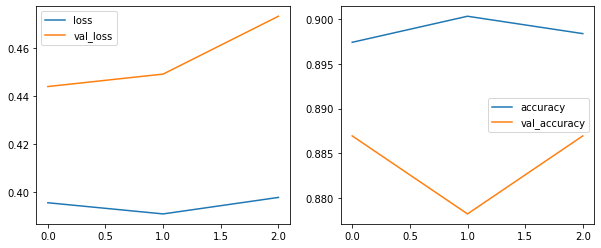

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

Checking the Accuracy of our model for Test data.

In [ ]:
test_loss, test_acc = model.evaluate(xTest,yTest, verbose=2)
print('\nTest accuracy:', test_acc)

16/16 - 0s - loss: 0.3684 - accuracy: 0.9004 - 178ms/epoch - 11ms/step

Test accuracy: 0.9004064798355103


Creating a array of all predictions with Test Data

In [ ]:
predictions = model.predict(xTest)
prediction_labels = np.argmax(predictions, axis=1)

16/16 [==============================] - 0s 10ms/step


Creating class labels array with corresponding values

'Neutral'= 0,
'Boredom'= 1,
'Engagement'= 2,
'Confusion' = 3,
'Frustration'= 4.

In [ ]:
class_names = ['Neutral','Boredom','Engagement','Confusion', 'Frustration' ]

A complete classification report all metrics.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(yTest, prediction_labels, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.91      0.99      0.95       424
     Boredom       1.00      0.54      0.70        24
  Engagement       0.00      0.00      0.00        22
   Confusion       0.20      0.10      0.13        10
 Frustration       0.67      0.83      0.74        12

    accuracy                           0.90       492
   macro avg       0.56      0.49      0.51       492
weighted avg       0.86      0.90      0.87       492



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print images batch and labels predictions
# Red color indicates Wrong Prediction
# Green color indicates Right Prediction

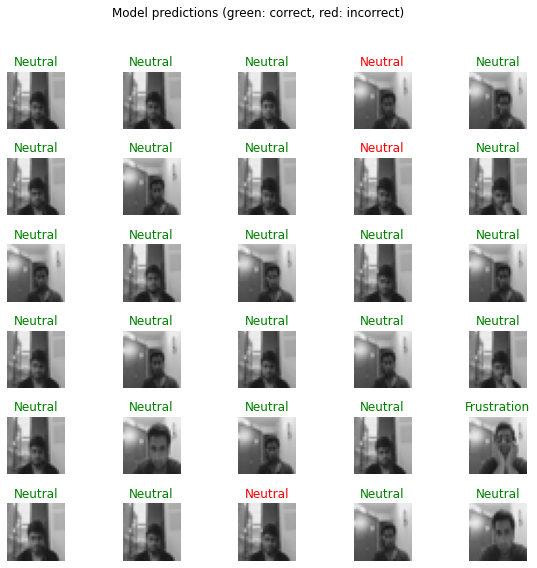

In [ ]:
from PIL import Image as im
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  array=xTest[n]
  ig= im.fromarray(array)
  plt.imshow(ig)
  color = "green" if np.argmax(predictions[n]) == yTest[n] else "red"
  plt.title(class_names[np.argmax(predictions[n])].title(),color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# VGG-19 pre-trained model

Creating a new dataset for VGG-19 model

In [ ]:
x2=[]
for i in range(164):
    for j in range(1,11):
        img1= Image.open("/content/drive/MyDrive/ET610-ENDSEM-Q1/Data/" + str(i)+"_"+str(j)+".jpg")
        i2= img1.resize((32, 32))
        np_img2 = np.array(i2)
        x2.append(np_img2)


Shape of new dataset

In [ ]:
X=np.array(x2,dtype='uint8')
np.shape(X)

(1640, 32, 32, 3)

Splitting the dataset into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
xTrain1, xTest1, yTrain1, yTest1 = train_test_split(X,labels, test_size = 0.3, random_state = 123)
train_images_3ch=xTrain1/255
test_images_3ch =xTest1/255

In [ ]:

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (1148, 32, 32, 3), of float64
Test_images.shape: (492, 32, 32, 3), of float64


Building the model

In [ ]:
INPUT_SHAPE = (32, 32, 3)
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)

vgg_layers.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
 layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
 print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe763142ad0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe76314c510> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe76314cd90> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe763147e10> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7631b8250> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe763198d50> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe766a6cbd0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7631ff2d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe763198b50> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe7631695d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe763169750> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe763141950> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe763171f50> True
<keras.layers.convolutional.conv2d.

In [ ]:
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [ ]:
EPOCHS = 100
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled,yTrain1,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/100
33/33 [==============================] - 145s 4s/step - loss: 1.5520 - accuracy: 0.5421 - val_loss: 0.6362 - val_accuracy: 0.8696
Epoch 2/100
33/33 [==============================] - 138s 4s/step - loss: 0.8714 - accuracy: 0.8151 - val_loss: 0.6115 - val_accuracy: 0.8696
Epoch 3/100
33/33 [==============================] - 139s 4s/step - loss: 0.8031 - accuracy: 0.8393 - val_loss: 0.6110 - val_accuracy: 0.8696
Epoch 4/100
33/33 [==============================] - 139s 4s/step - loss: 0.7817 - accuracy: 0.8403 - val_loss: 0.5890 - val_accuracy: 0.8696
Epoch 5/100
33/33 [==============================] - 136s 4s/step - loss: 0.7790 - accuracy: 0.8403 - val_loss: 0.6193 - val_accuracy: 0.8696
Epoch 6/100
33/33 [==============================] - 134s 4s/step - loss: 0.7837 - accuracy: 0.8412 - val_loss: 0.5897 - val_accuracy: 0.8696
Epoch 6: early stopping


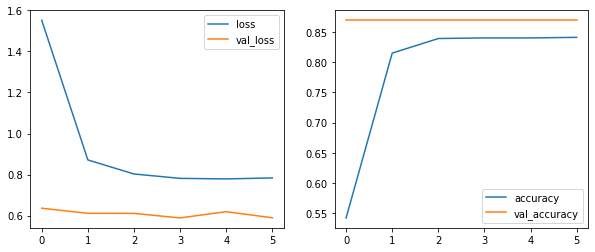

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

Accuracy of pre-trained Model

In [ ]:
test_loss, test_acc = model.evaluate(test_images_3ch,yTest1, verbose=2) #accuracy using pre-trained VGG19 

print('\nTest accuracy after using pre-trained model', test_acc)

16/16 - 7s - loss: 0.6798 - accuracy: 0.8618 - 7s/epoch - 427ms/step

Test accuracy after using pre-trained model 0.8617886304855347


In [ ]:
predictions1 = model.predict(test_images_3ch)
prediction_labels = np.argmax(predictions1, axis=1)

16/16 [==============================] - 7s 427ms/step


Classification Report for the pre trained model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(yTest1, prediction_labels, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.86      1.00      0.93       424
     Boredom       0.00      0.00      0.00        24
  Engagement       0.00      0.00      0.00        22
   Confusion       0.00      0.00      0.00        10
 Frustration       0.00      0.00      0.00        12

    accuracy                           0.86       492
   macro avg       0.17      0.20      0.19       492
weighted avg       0.74      0.86      0.80       492



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CODE for Custom Image Testing

In [ ]:
lst=[]
import urllib.request
urllib.request.urlretrieve(
  'Image_url',
   "file_name")           # enter the url of image to be tested and file name
  
img = Image.open("  file_name  ")
img= img.resize((32, 32))
np_img = np.array(img)
lst.append(np_img2)

In [ ]:
X1=np.array(lst,dtype='uint8')
X1=X1/255

In [ ]:
predict_image=model.predict(X1)

1/1 [==============================] - 0s 154ms/step


In [ ]:
print( "The predicted output for the given image is", class_names[np.argmax(predict_image[0])])

The predicted output for the given image is Neutral
